# **Sentiment Analysis: Twitter US Airline Sentiment with DistilBERT**
This notebook performs:
1. Domain-adaptive masked-LM fine-tuning on airline tweets  
2. 3-way sentiment classification fine-tuning  
3. Evaluation and demo predictions  


## **Install & Import Dependencies**
- Install Hugging Face Transformers, Datasets, and Evaluate libraries  
- Import PyTorch, Datasets, Transformers, and evaluation metrics  


In [1]:
!pip install -q --upgrade transformers datasets evaluate



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 105.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 38.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 16.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cu

In [1]:
# Imports (after restart!)
import torch
from datasets import load_dataset, concatenate_datasets
from transformers import (
    AutoTokenizer,
    AutoModelForMaskedLM,
    AutoModelForSequenceClassification,
    DataCollatorForLanguageModeling,
    Trainer,
    TrainingArguments,
)
import evaluate

# Verify fsspec version (should be >= 2023.11.0)
import fsspec
print(f"fsspec version: {fsspec.__version__}")

# Check device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")


fsspec version: 2025.3.0
Using device: cuda


## **Load the Twitter US Airline Sentiment Dataset**
- Uses Hugging Face `tweet_eval` with the `sentiment` config  
- Splits: train (8000), validation (2000), test (2000)  


In [2]:
# Load the dataset
ds = load_dataset("tweet_eval", "sentiment")
train_ds = ds["train"]
val_ds   = ds["validation"]
test_ds  = ds["test"]

# Inspect a few examples
print(train_ds.features)
print(train_ds[0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/3.78M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/901k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/167k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/45615 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12284 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}
{'text': '"QT @user In the original draft of the 7th book, Remus Lupin survived the Battle of Hogwarts. #HappyBirthdayRemusLupin"', 'label': 2}


In [14]:
# Inspect dataset features
print("\nDataset features:")
print(train_ds.features)



Dataset features:
{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['negative', 'neutral', 'positive'], id=None)}


In [15]:
# Convert to pandas DataFrame for easy inspection
train_df = pd.DataFrame(train_ds[:10])  # Show first 10 rows
print("\nHead of train dataset:")
print(train_df)


Head of train dataset:
                                                text  label
0  "QT @user In the original draft of the 7th boo...      2
1  "Ben Smith / Smith (concussion) remains out of...      1
2  Sorry bout the stream last night I crashed out...      1
3  Chase Headley's RBI double in the 8th inning o...      1
4  @user Alciato: Bee will invest 150 million in ...      2
5  @user LIT MY MUM 'Kerry the louboutins I wonde...      2
6  "\"""" SOUL TRAIN\"""" OCT 27 HALLOWEEN SPECIA...      2
7  So disappointed in wwe summerslam! I want to s...      0
8  "This is the last Sunday w/o football .....,NF...      2
9  @user @user CENA & AJ sitting in a tree K-I-S-...      1


/tmp/ipython-input-16-1103201254.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=label_df, x="sentiment", palette="pastel")


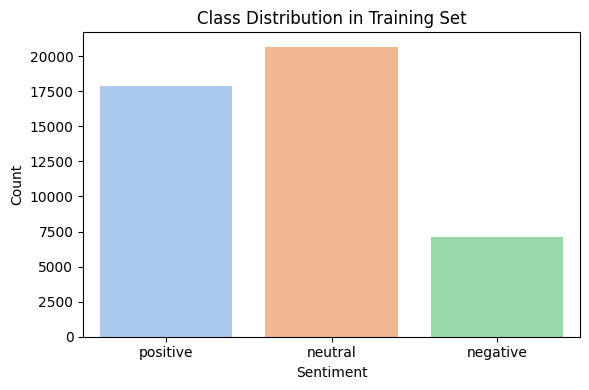

In [16]:
# Plot class distribution
label_map = {0: "negative", 1: "neutral", 2: "positive"}
train_labels = [label_map[label] for label in train_ds["label"]]

# Create a DataFrame to plot
label_df = pd.DataFrame(train_labels, columns=["sentiment"])

plt.figure(figsize=(6, 4))
sns.countplot(data=label_df, x="sentiment", palette="pastel")
plt.title("Class Distribution in Training Set")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.tight_layout()
plt.savefig("class_distribution.png")
plt.show()

##  **Domain-Adaptive Masked-LM Fine-Tuning**
- Further pre-train DistilBERT on all tweets (train + val)  
- Creates a checkpoint: `distilbert-domain-adapt-tweets/`  


In [4]:
def domain_adapt_lm(dataset,
                    base_model="distilbert-base-uncased",
                    output_dir="distilbert-domain-adapt-tweets",
                    epochs=1,
                    batch_size=16):
    # Load tokenizer & model
    tokenizer = AutoTokenizer.from_pretrained(base_model)
    model = AutoModelForMaskedLM.from_pretrained(base_model).to(device)

    # Tokenize only the "text" field
    def tokenize_lm(ex):
        return tokenizer(
            ex["text"],
            truncation=True,
            padding="max_length",
            max_length=128,
        )
    tokenized = dataset.map(tokenize_lm, batched=True,
                            remove_columns=["text", "label"])

    # Data collator for MLM
    collator = DataCollatorForLanguageModeling(
        tokenizer, mlm=True, mlm_probability=0.15
    )

    # Training arguments
    args = TrainingArguments(
        output_dir=output_dir,
        overwrite_output_dir=True,
        num_train_epochs=epochs,
        per_device_train_batch_size=batch_size,
        logging_steps=500,
        save_steps=2000,
        fp16=True,
        report_to=["tensorboard"]
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=tokenized,
        data_collator=collator,
    )
    trainer.train()
    trainer.save_model(output_dir)
    return tokenizer, output_dir

# Run domain adaptation on train+val
tokenizer, lm_checkpoint = domain_adapt_lm(
    concatenate_datasets([train_ds, val_ds]),
    epochs=3,
    batch_size=16,
)


Map:   0%|          | 0/47615 [00:00<?, ? examples/s]

Step,Training Loss
500,3.395900
1000,3.182400
1500,3.111400
2000,3.090200
2500,3.001200
3000,3.003100
3500,2.865900
4000,2.859200
4500,2.825900
5000,2.791800


##  **Fine-Tune for 3-Way Sentiment Classification**
- Load the domain-adapted checkpoint  
- Fine-tune for 3 classes (negative, neutral, positive)  
- Saves best model to `distilbert-sentiment-tweets/`  



>> Training with lr = 5e-05


Map:   0%|          | 0/45615 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-domain-adapt-tweets and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.745300
1000,0.682500
1500,0.653100
2000,0.639500
2500,0.614700
3000,0.560900
3500,0.456000
4000,0.434400
4500,0.410800
5000,0.405300


Validation Accuracy @ lr=5e-05: 0.7440


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-domain-adapt-tweets and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



>> Training with lr = 3e-05


Step,Training Loss
500,0.743100
1000,0.673200
1500,0.644600
2000,0.634400
2500,0.606800
3000,0.566000
3500,0.477900
4000,0.463200
4500,0.446200
5000,0.436700


Validation Accuracy @ lr=3e-05: 0.7530


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-domain-adapt-tweets and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



>> Training with lr = 2e-05


Step,Training Loss
500,0.751400
1000,0.670900
1500,0.643200
2000,0.636200
2500,0.606300
3000,0.577000
3500,0.509000
4000,0.490700
4500,0.479800
5000,0.468000


Validation Accuracy @ lr=2e-05: 0.7535

## Hyperparameter Results
|   learning_rate |   validation_accuracy |
|----------------:|----------------------:|
|           5e-05 |                0.744  |
|           3e-05 |                0.753  |
|           2e-05 |                0.7535 |

Best model saved for learning rate = 2e-05 with accuracy = 0.7535


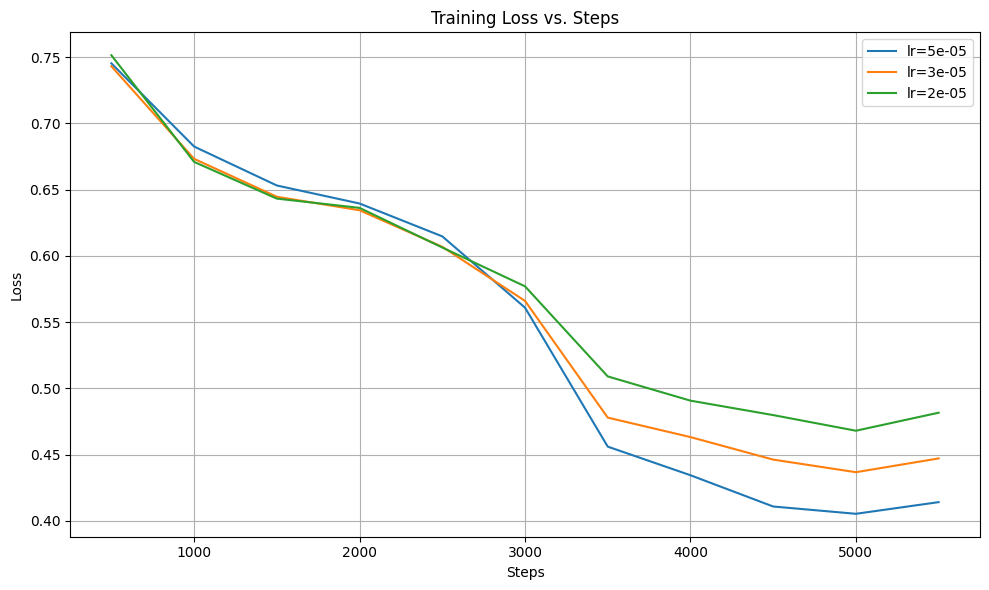

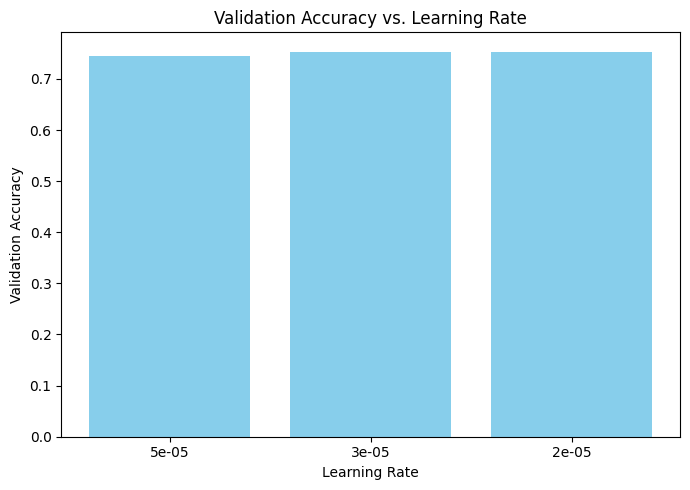

In [6]:
import evaluate, pandas as pd
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, TrainerCallback
import matplotlib.pyplot as plt
import torch
import numpy as np

accuracy = evaluate.load("accuracy")
results = []
history_dict = {}

best_model = None
best_accuracy = 0
best_lr = None

class HistoryRecorder(TrainerCallback):
    def __init__(self):
        self.losses = []
        self.steps = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and "loss" in logs:
            self.losses.append(logs["loss"])
            self.steps.append(state.global_step)

for lr in [5e-5, 3e-5, 2e-5]:
    print(f"\n>> Training with lr = {lr:.0e}")

    def tokenize_cl(ex):
        return tokenizer(ex["text"], truncation=True, padding="max_length", max_length=128)

    train_tok = train_ds.map(tokenize_cl, batched=True, remove_columns=["text"])
    val_tok = val_ds.map(tokenize_cl, batched=True, remove_columns=["text"])

    args = TrainingArguments(
        output_dir=f"tmp_lr_{lr}",
        overwrite_output_dir=True,
        num_train_epochs=2,
        learning_rate=lr,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        do_train=True,
        do_eval=True,
        eval_steps=500,
        save_steps=500,
        logging_steps=500,
        load_best_model_at_end=False,
        report_to=[]
    )

    model = AutoModelForSequenceClassification.from_pretrained(
        lm_checkpoint, num_labels=3
    ).to(device)

    # Callback to record training loss
    history_callback = HistoryRecorder()

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_tok,
        eval_dataset=val_tok,
        compute_metrics=lambda p: {
            "accuracy": accuracy.compute(
                predictions=p.predictions.argmax(-1),
                references=p.label_ids
            )["accuracy"]
        },
        callbacks=[history_callback]
    )

    trainer.train()
    metrics = trainer.evaluate()
    val_acc = metrics.get("eval_accuracy", metrics.get("accuracy"))
    print(f"Validation Accuracy @ lr={lr:.0e}: {val_acc:.4f}")
    results.append((lr, val_acc))
    history_dict[lr] = {
        "losses": history_callback.losses,
        "steps": history_callback.steps
    }

    # Save best model
    if val_acc > best_accuracy:
        best_accuracy = val_acc
        best_model = model
        best_lr = lr
        model.save_pretrained("best_model")
        tokenizer.save_pretrained("best_model")




## Hyperparameter Results
|   learning_rate |   validation_accuracy |
|----------------:|----------------------:|
|           5e-05 |                0.744  |
|           3e-05 |                0.753  |
|           2e-05 |                0.7535 |

Best model saved for learning rate = 2e-05 with accuracy = 0.7535


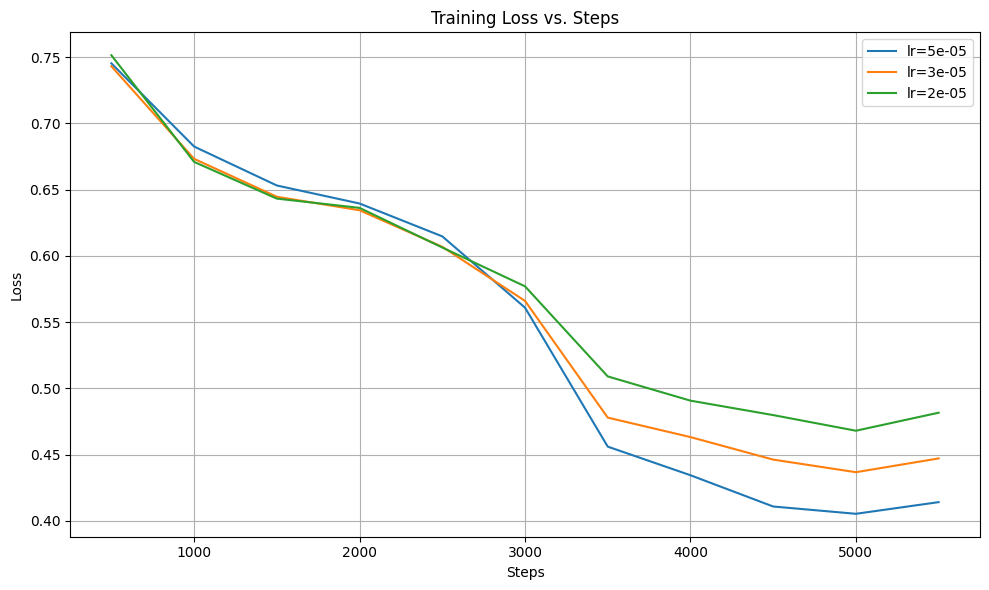

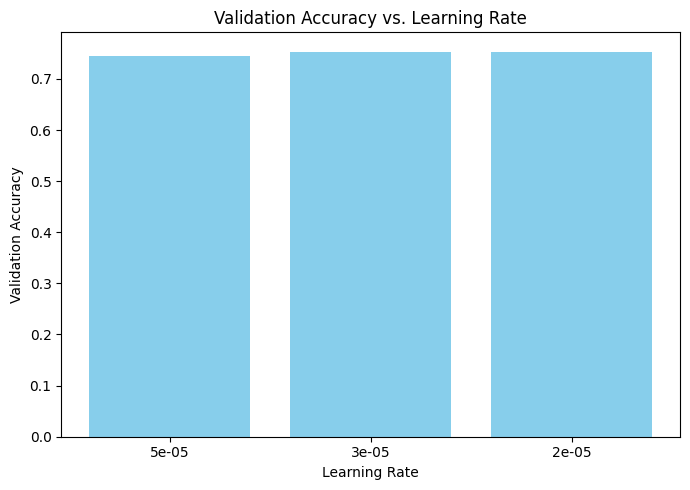

In [7]:

# Summary table
df = pd.DataFrame(results, columns=["learning_rate", "validation_accuracy"])
print("\n## Hyperparameter Results")
print(df.to_markdown(index=False))
print(f"\nBest model saved for learning rate = {best_lr:.0e} with accuracy = {best_accuracy:.4f}")

# Plot training loss vs. steps for each learning rate
plt.figure(figsize=(10, 6))
for lr in history_dict:
    plt.plot(history_dict[lr]["steps"], history_dict[lr]["losses"], label=f"lr={lr:.0e}")
plt.title("Training Loss vs. Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("loss_vs_steps.png")
plt.show()

# Optional: bar plot for validation accuracies
plt.figure(figsize=(7, 5))
plt.bar([f"{lr:.0e}" for lr, _ in results], [acc for _, acc in results], color='skyblue')
plt.title("Validation Accuracy vs. Learning Rate")
plt.xlabel("Learning Rate")
plt.ylabel("Validation Accuracy")
plt.tight_layout()
plt.savefig("val_accuracy_bar.png")
plt.show()

##  Evaluate on the Test Set
- Tokenize test split  
- Report accuracy & F1 on hold-out data  


In [10]:

import os
os.environ["WANDB_DISABLED"] = "true"


In [11]:
# ── Load best model & tokenizer ──
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer
from sklearn.metrics import classification_report, confusion_matrix
import evaluate

# Load the saved model and tokenizer from 'best_model' directory
model = AutoModelForSequenceClassification.from_pretrained("best_model").to(device)
tokenizer = AutoTokenizer.from_pretrained("best_model")

# ── Tokenize the test dataset ──
def tokenize_for_eval(ex):
    return tokenizer(ex["text"], truncation=True, padding="max_length", max_length=128)

test_tok = test_ds.map(tokenize_for_eval, batched=True, remove_columns=["text"])

# ── Use Trainer to get predictions ──
trainer = Trainer(model=model)
pred_output = trainer.predict(test_tok)

# Get predicted and true labels
preds = pred_output.predictions.argmax(-1)
labels = pred_output.label_ids

# ── Compute evaluation metrics ──
acc_m  = evaluate.load("accuracy")
prec_m = evaluate.load("precision")
rec_m  = evaluate.load("recall")
f1_m   = evaluate.load("f1")

print(f"Accuracy : {acc_m.compute(predictions=preds, references=labels)['accuracy']:.4f}")
print(f"Precision: {prec_m.compute(predictions=preds, references=labels, average='weighted')['precision']:.4f}")
print(f"Recall   : {rec_m.compute(predictions=preds, references=labels, average='weighted')['recall']:.4f}")
print(f"F1 Score : {f1_m.compute(predictions=preds, references=labels, average='weighted')['f1']:.4f}")

# ── Classification Report and Confusion Matrix ──
print("\nClassification Report:")
print(classification_report(labels, preds, target_names=["negative", "neutral", "positive"]))

print("Confusion Matrix:")
print(confusion_matrix(labels, preds))


Map:   0%|          | 0/12284 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Accuracy : 0.7008
Precision: 0.7030
Recall   : 0.7008
F1 Score : 0.7003

Classification Report:
              precision    recall  f1-score   support

    negative       0.68      0.76      0.72      3972
     neutral       0.73      0.66      0.69      5937
    positive       0.67      0.69      0.68      2375

    accuracy                           0.70     12284
   macro avg       0.69      0.71      0.70     12284
weighted avg       0.70      0.70      0.70     12284

Confusion Matrix:
[[3037  832  103]
 [1305 3922  710]
 [ 100  625 1650]]


Confusion Matrix:
[[3037  832  103]
 [1305 3922  710]
 [ 100  625 1650]]


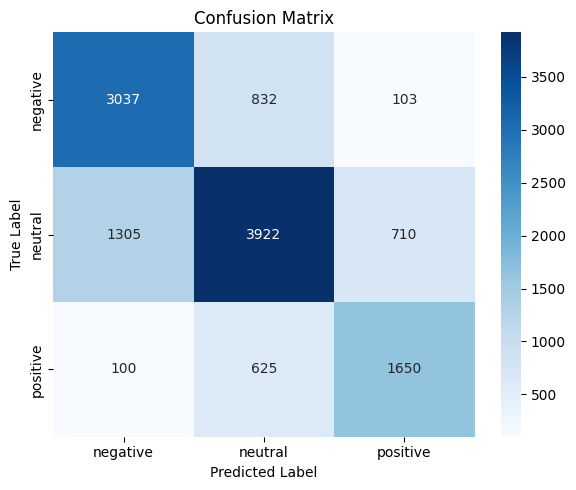

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Print the raw confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(labels, preds)
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["negative", "neutral", "positive"],
            yticklabels=["negative", "neutral", "positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.savefig("confusion_matrix.png")
plt.show()


##  Quick Prediction Demo
- Inference on a few example tweets  


In [12]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch

# Load the best model and tokenizer from saved folder
device = "cuda" if torch.cuda.is_available() else "cpu"
model = AutoModelForSequenceClassification.from_pretrained("best_model").to(device)
tokenizer = AutoTokenizer.from_pretrained("best_model")

# Define prediction function
def predict(texts):
    inputs = tokenizer(
        texts,
        truncation=True,
        padding=True,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        logits = model(**inputs).logits

    preds = logits.argmax(-1).cpu().numpy()
    labels = ["negative", "neutral", "positive"]
    return [labels[p] for p in preds]

# Sample texts to test
samples = [
    "I love how @Delta handled my flight issue—superb service!",
    "Worst airline ever. My bag was lost and no apology."
]

# Run prediction
print(predict(samples))


['positive', 'negative']
